# ===========================================================
# Implement basic dynamic models to estimate influence matrices
# ===========================================================

## Goals:
####   1. Analyze at the dynamics of the influence matrices
####   2. Implement Structurl Balance Theory and etc. models to estimate influence matrices in the jeopardy dataset

#### Last update: 17 Jan 2020

# Imports

In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals

import pdb
import heapq
import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import imp
from collections import defaultdict
import sys
sys.path.insert(0, '../src/')
%matplotlib inline

import utils
import pogs_jeopardy_log_lib
import mytools

/home/omid/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/omid/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def reload():
    imp.reload(mytools)
    imp.reload(utils)
    imp.reload(pogs_jeopardy_log_lib)

# Parameters

In [3]:
directory = '/home/omid/Datasets/Jeopardy/'

# Helper functions

In [4]:
def plot_influence_dynamics(team_info):
    print('Team {}:'.format(team_info.team_id))
    # Dynamics of the opinion i w.r.t. j:
    plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    index = 221
    tickers = ['p', 'o', '*', '^']
    for i in range(4):
        plt.subplot(221 + i)
        for j in range(4):
            dynamics_of_opinion_i_of_j = np.array(team_info.member_influences)[:, i][:, j]
            plt.plot(dynamics_of_opinion_i_of_j, '-' + tickers[j])
        plt.legend([1, 2, 3, 4])
        plt.title('Member {}\'s opinion dynamics from members.'.format(i+1));

Team 37:


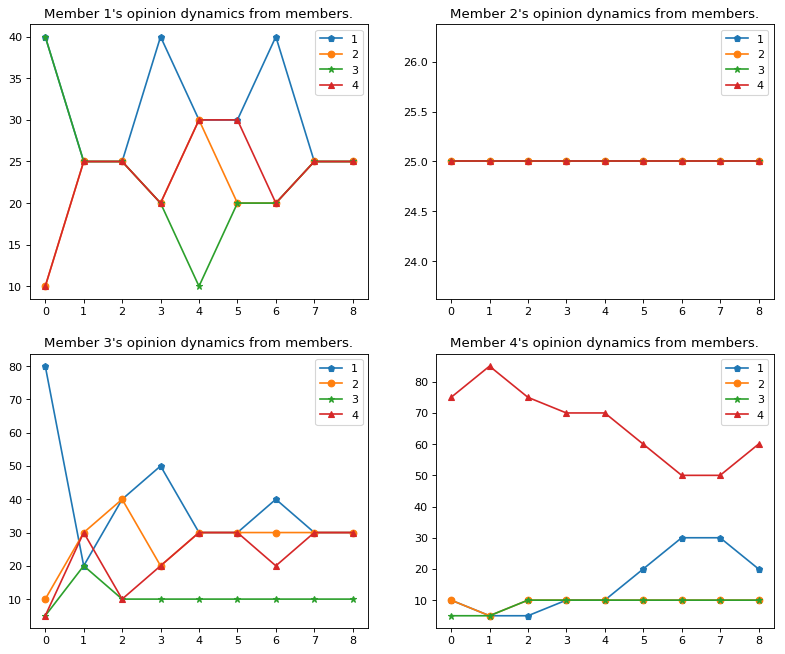

In [11]:
plot_influence_dynamics(team_info)

In [36]:
team_info.team_array

['pogs30.3', 'pogs30.2', 'pogs30.1', 'pogs30.4']

In [41]:
team_info.group_answers_chosen

{1: {138: 'Radio Waves',
  139: 'Radio Waves',
  140: 'Radio Waves',
  141: 'Radio Waves'},
 2: {138: 'citric acid',
  139: 'citric acid',
  140: 'citric acid',
  141: 'citric acid'},
 3: {138: 'Richter scale',
  139: 'Richter scale',
  140: 'Richter scale',
  141: 'Richter scale'},
 4: {138: 'Helium', 139: 'Helium', 140: 'Helium', 141: 'Helium'},
 5: {138: 'Paul Allen',
  139: 'Paul Allen',
  140: 'Paul Allen',
  141: 'Paul Allen'},
 6: {138: 'Apple', 139: 'Apple', 140: 'Apple', 141: 'Apple'},
 7: {138: 'Wolffia globosa',
  139: 'Wolffia globosa',
  140: 'Wolffia globosa',
  141: 'Wolffia globosa'},
 8: {138: 'Japan', 139: 'Japan', 140: 'Japan', 141: 'Japan'},
 9: {138: 'Analytical Engine',
  139: 'Analytical Engine',
  140: 'Analytical Engine',
  141: 'Analytical Engine'},
 10: {138: 'Alan Shephard',
  139: 'Alan Shephard',
  140: 'Alan Shephard',
  141: 'Alan Shephard'},
 11: {138: '330', 139: '330', 140: '330', 141: '330'},
 12: {138: 'Mars', 139: 'Mars', 140: 'Mars', 141: 'Mars'},

In [42]:
sorted(team_info.members)

[138, 139, 140, 141]

In [37]:
team_info.teamMember

92    pogs30.3
93    pogs30.2
94    pogs30.1
95    pogs30.4
Name: displayName, dtype: object

In [38]:
team_info.team_member

92    pogs30.3
93    pogs30.2
94    pogs30.1
95    pogs30.4
Name: displayName, dtype: object

In [39]:
team_info.team_subjects

,teamId,sender_subject_id
0,7,18
1,7,20
2,7,19
3,7,17
4,10,28
5,10,25
6,10,26
7,10,27
8,11,31
9,11,30


In [35]:
team_info.pre_experiment_rating

[{0: 5.0, 1: 3.0, 2: 4.0},
 {0: 3.0, 1: 4.0, 2: 2.0},
 {0: 3.0, 1: 2.0, 2: 2.0},
 {0: 3.0, 1: 4.0, 2: 4.0}]

In [34]:
team_info.team_member

92    pogs30.3
93    pogs30.2
94    pogs30.1
95    pogs30.4
Name: displayName, dtype: object

In [24]:
team_info.teamMember

92    pogs30.3
93    pogs30.2
94    pogs30.1
95    pogs30.4
Name: displayName, dtype: object

In [26]:
team_info.messages[0]

,id,event_type,event_content,timestamp,completed_task_id,sender_subject_id,receiver_subject_id,session_id,sender,receiver,extra_data,team_id
11993,15275,COMMUNICATION_MESSAGE,we good on radio waves then?,2019-05-21 11:14:26,198,141,\N,32,pogs30.4,\N,\N,37
11996,15278,COMMUNICATION_MESSAGE,Yes,2019-05-21 11:14:30,198,140,\N,32,pogs30.3,\N,\N,37
11997,15279,COMMUNICATION_MESSAGE,thats what i was thinkin,2019-05-21 11:14:33,198,138,\N,32,pogs30.1,\N,\N,37
11999,15281,COMMUNICATION_MESSAGE,yeet,2019-05-21 11:14:34,198,141,\N,32,pogs30.4,\N,\N,37


In [16]:
np.array(team_info.member_influences)[:, 0][:, 2]

array([40, 25, 25, 20, 10, 20, 20, 25, 25])

In [12]:
for i in range(len(team_info.member_influences)):
    print(np.array(team_info.member_influences[i]))
    print('\n')

[[40 10 40 10]
 [25 25 25 25]
 [80 10  5  5]
 [10 10  5 75]]


[[25 25 25 25]
 [25 25 25 25]
 [20 30 20 30]
 [ 5  5  5 85]]


[[25 25 25 25]
 [25 25 25 25]
 [40 40 10 10]
 [ 5 10 10 75]]


[[40 20 20 20]
 [25 25 25 25]
 [50 20 10 20]
 [10 10 10 70]]


[[30 30 10 30]
 [25 25 25 25]
 [30 30 10 30]
 [10 10 10 70]]


[[30 20 20 30]
 [25 25 25 25]
 [30 30 10 30]
 [20 10 10 60]]


[[40 20 20 20]
 [25 25 25 25]
 [40 30 10 20]
 [30 10 10 50]]


[[25 25 25 25]
 [25 25 25 25]
 [30 30 10 30]
 [30 10 10 50]]


[[25 25 25 25]
 [25 25 25 25]
 [30 30 10 30]
 [20 10 10 60]]




# Loading teams' logs

In [5]:
data = utils.load_it(directory + 'Teams_logs.pk')

In [6]:
len(data)

49

# Dynamics of influence matrices

In [11]:
frob_norm_of_consecutive = defaultdict(list)
for team_id, team_log in data.items():
    for index in range(1, len(team_log.member_influences)):
        curr = utils.make_matrix_row_stochastic(
            np.matrix(team_log.member_influences[index]) / 100)
        prev = utils.make_matrix_row_stochastic(
            np.matrix(team_log.member_influences[index - 1]) / 100)
        diff = curr - prev
        frob_norm_of_consecutive[team_id].append(np.linalg.norm(diff, ord=2))

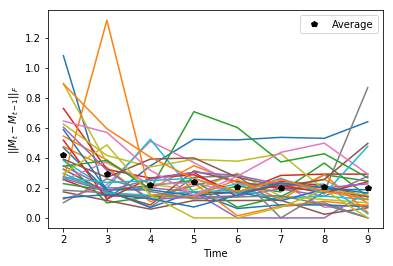

In [12]:
f = plt.figure()
team_diffs = np.zeros(8)
cnt = 0
for team_id, team_diff in frob_norm_of_consecutive.items():
    if len(team_diff) == 8:
        team_diffs += team_diff
        cnt += 1
        plt.plot(np.arange(2, 10), team_diff)
team_diffs /= cnt
# plt.title('Consecutive Frobenius norm difference of influence matrix in every team')
plt.xlabel('Time')
plt.ylabel('$||M_t - M_{t-1}||_F$')
plt.plot(np.arange(2, 10), team_diffs, 'p', color='black', label='Average')
plt.legend()
f.savefig('consecutive_frob_norm_of_influence_matrices.pdf', bbox_inches='tight')
f.savefig('consecutive_frob_norm_of_influence_matrices.png', bbox_inches='tight')

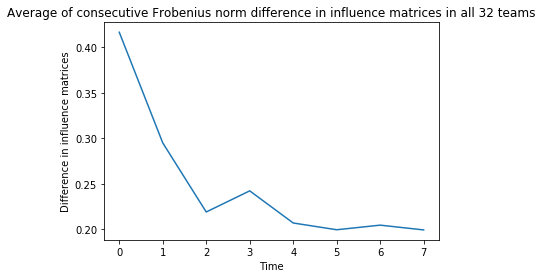

In [13]:
plt.plot(team_diffs);
plt.title('Average of consecutive Frobenius norm difference in influence matrices in all {} teams'.format(cnt))
plt.xlabel('Time')
plt.ylabel('Difference in influence matrices');

# Relationship of influence matrix dynamics with performance

In [41]:
all_influence_matrices_dict = {}
for team_id, team_log in data.items():
    influence_matrices = []
    for t in range(len(team_log.member_influences)):
        original_influence_matrix = np.array(team_log.member_influences[t]) / 100
        influence_matrices.append(
            utils.make_matrix_row_stochastic(
                original_influence_matrix))
    all_influence_matrices_dict[team_id] = influence_matrices

## With team performance

### How does change of influence in well and worse scoring teams looklike

In [22]:
final_team_score = []
for team_id, team_data in data.items():
    if 45 in team_data.accumulated_score:  # If they answer all questions.
        heapq.heappush(final_team_score, (team_data.accumulated_score[45], team_id))
low_to_high_performing_teams = []
low_to_high_performing_team_scores = []
while final_team_score:
    (team_score, team_id) = heapq.heappop(final_team_score)
    low_to_high_performing_teams.append(team_id)
    low_to_high_performing_team_scores.append(team_score)

#### Bad ones

Team 34:

Members order: [125, 123, 122, 124] 

122: {'correct_rate': 0.4222222222222222, 'hardness_weighted_correct_rate': 0.43333333333333335}
123: {'correct_rate': 0.4666666666666667, 'hardness_weighted_correct_rate': 0.45555555555555555}
124: {'correct_rate': 0.37777777777777777, 'hardness_weighted_correct_rate': 0.3}
125: {'correct_rate': 0.6, 'hardness_weighted_correct_rate': 0.5222222222222223}


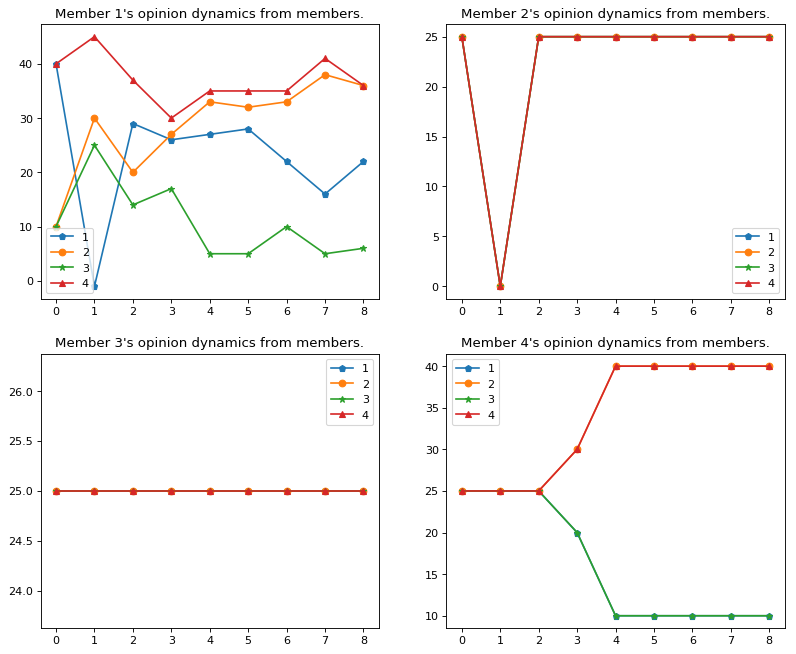

In [159]:
team_id = low_to_high_performing_teams[0]
plot_influence_dynamics(data[team_id])
print('\nMembers order:', data[team_id].members, '\n')
for member, perf in individual_performance_rates[team_id].items():
    print('{}: {}'.format(member, perf))

Team 42:

Members order: [160, 161, 159, 158] 

160: {'correct_rate': 0.5555555555555556, 'hardness_weighted_correct_rate': 0.5111111111111111}
161: {'correct_rate': 0.6888888888888889, 'hardness_weighted_correct_rate': 0.6444444444444445}
158: {'correct_rate': 0.35555555555555557, 'hardness_weighted_correct_rate': 0.28888888888888886}
159: {'correct_rate': 0.4222222222222222, 'hardness_weighted_correct_rate': 0.3888888888888889}


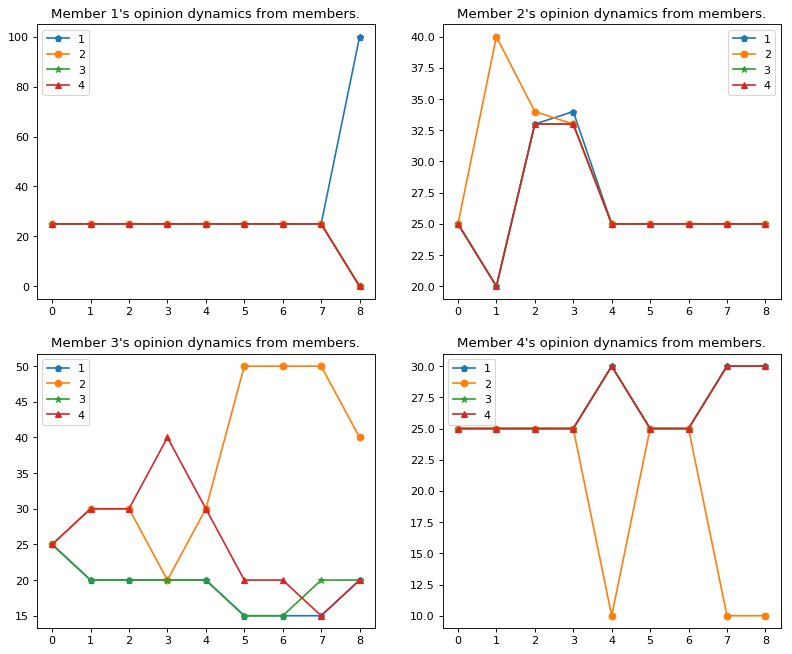

In [160]:
team_id = low_to_high_performing_teams[1]
plot_influence_dynamics(data[team_id])
print('\nMembers order:', data[team_id].members, '\n')
for member, perf in individual_performance_rates[team_id].items():
    print('{}: {}'.format(member, perf))

Team 85:

Members order: [292, 291, 294, 293] 

291: {'correct_rate': 0.4, 'hardness_weighted_correct_rate': 0.36666666666666664}
292: {'correct_rate': 0.5555555555555556, 'hardness_weighted_correct_rate': 0.5111111111111111}
293: {'correct_rate': 0.4444444444444444, 'hardness_weighted_correct_rate': 0.4222222222222222}
294: {'correct_rate': 0.4888888888888889, 'hardness_weighted_correct_rate': 0.4111111111111111}


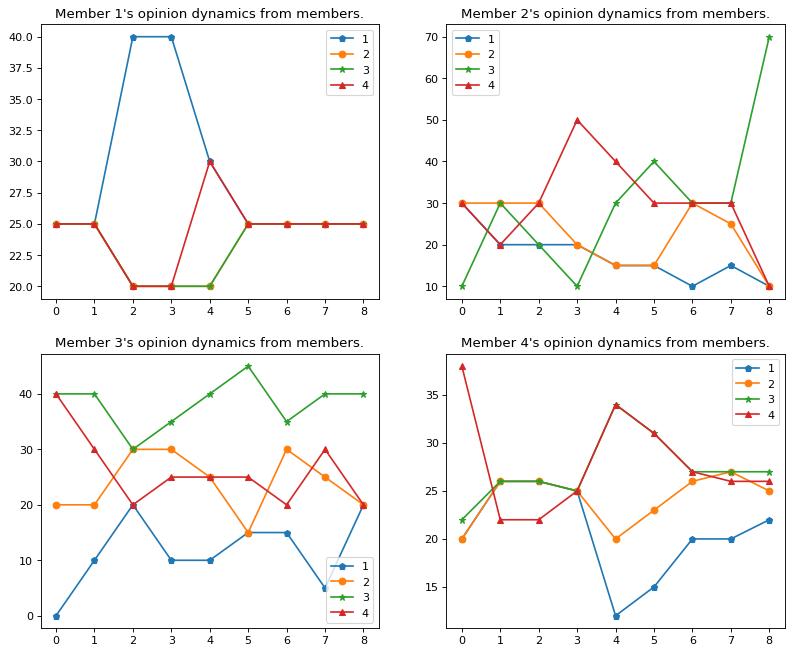

In [163]:
team_id = low_to_high_performing_teams[4]
plot_influence_dynamics(data[team_id])
print('\nMembers order:', data[team_id].members, '\n')
for member, perf in individual_performance_rates[team_id].items():
    print('{}: {}'.format(member, perf))

#### Good ones

Team 48:

Members order: [186, 188, 187, 189] 

186: {'correct_rate': 0.6222222222222222, 'hardness_weighted_correct_rate': 0.5888888888888889}
187: {'correct_rate': 0.4222222222222222, 'hardness_weighted_correct_rate': 0.4}
188: {'correct_rate': 0.5777777777777777, 'hardness_weighted_correct_rate': 0.4777777777777778}
189: {'correct_rate': 0.4666666666666667, 'hardness_weighted_correct_rate': 0.45555555555555555}


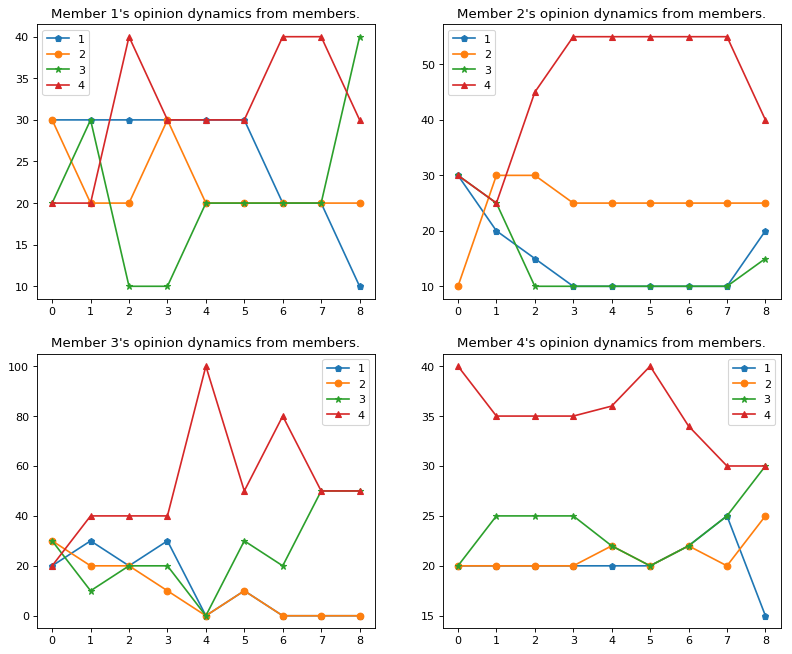

In [158]:
team_id = low_to_high_performing_teams[-10]
plot_influence_dynamics(data[team_id])
print('\nMembers order:', data[team_id].members, '\n')
for member, perf in individual_performance_rates[team_id].items():
    print('{}: {}'.format(member, perf))

Team 36:

Members order: [135, 134, 136, 137] 

136: {'correct_rate': 0.7045454545454546, 'hardness_weighted_correct_rate': 0.7045454545454546}
137: {'correct_rate': 0.5777777777777777, 'hardness_weighted_correct_rate': 0.6}
134: {'correct_rate': 0.4888888888888889, 'hardness_weighted_correct_rate': 0.43333333333333335}
135: {'correct_rate': 0.35555555555555557, 'hardness_weighted_correct_rate': 0.36666666666666664}


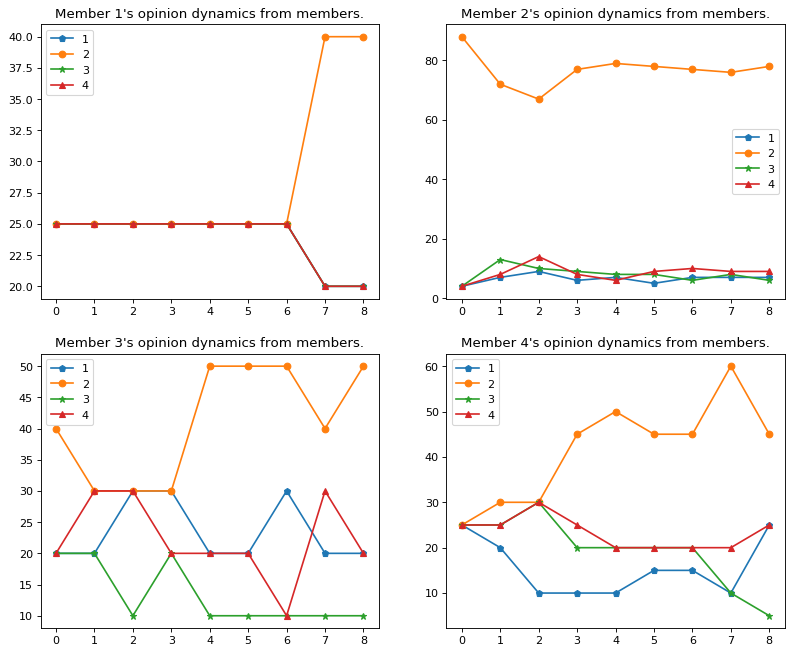

In [147]:
team_id = low_to_high_performing_teams[-2]
plot_influence_dynamics(data[team_id])
print('\nMembers order:', data[team_id].members, '\n')
for member, perf in individual_performance_rates[team_id].items():
    print('{}: {}'.format(member, perf))

Team 49:

Members order: [192, 191, 190, 193] 

192: {'correct_rate': 0.5111111111111111, 'hardness_weighted_correct_rate': 0.5111111111111111}
193: {'correct_rate': 0.4666666666666667, 'hardness_weighted_correct_rate': 0.43333333333333335}
190: {'correct_rate': 0.7111111111111111, 'hardness_weighted_correct_rate': 0.6666666666666666}
191: {'correct_rate': 0.6444444444444445, 'hardness_weighted_correct_rate': 0.5777777777777777}


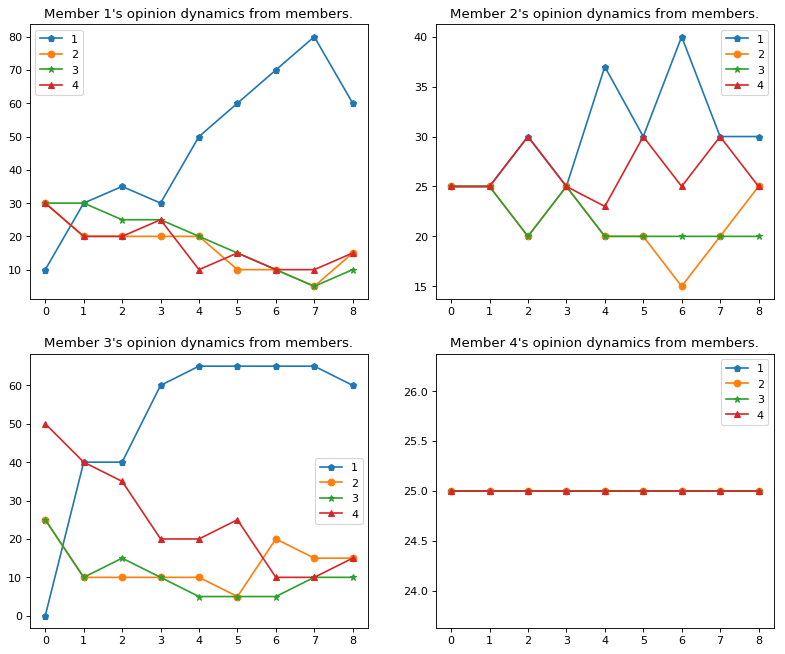

In [148]:
team_id = low_to_high_performing_teams[-1]
plot_influence_dynamics(data[team_id])
print('\nMembers order:', data[team_id].members, '\n')
for member, perf in individual_performance_rates[team_id].items():
    print('{}: {}'.format(member, perf))

### Whether increasing team score is correlated with decrease in frobenius norm of influence matrices

In [55]:
c = 0
sig_c = 0
for team_id, team_log in data.items():
    if team_id in frob_norm_of_consecutive and 45 in team_log.accumulated_score:
        c += 1
        this_team_diff = frob_norm_of_consecutive[team_id]
        this_team_perf = [team_log.accumulated_score[index] for index in [10, 15, 20, 25, 30, 35, 40, 45]]
        r_val, p_val = sp.stats.pearsonr(this_team_diff, this_team_perf)
        if p_val < 0.05:
            print(r_val, p_val)
            sig_c += 1
#         utils.compute_relationship(this_team_diff, this_team_perf, maxlag=1)

print('\nOnly {:.2f}% were statistically significant.'.format(100 * sig_c / c))

-0.7680855906773422 0.02601105129486113
-0.7372230008732072 0.036892618794485035
-0.7594052826922197 0.02883718158099217
-0.7873209221948606 0.02037694101689579
-0.7217222048396326 0.043255481271374005
-0.7456499838588502 0.033689009160089003
-0.9354677888207428 0.0006397487651953204

Only 22.58% were statistically significant.


## With individual performance

In [56]:
hardness_weights = {
    pogs_jeopardy_log_lib.Level.EASY: 1,
    pogs_jeopardy_log_lib.Level.MEDIUM: 2,
    pogs_jeopardy_log_lib.Level.HARD: 3}
minimum_number_of_questions_to_answer = 44

questions = data[37].game_info.questions
individual_performances = {}
for team_id, team_log in data.items():
    individual_performances[team_id] = defaultdict(
        lambda: {'#correct': 0,
                 '#questions': 0,
                 '#hardness_weighted_correct': 0,
                 '#hardness_weighted_questions': 0})
    for qid, team_answers in team_log.individual_answers_chosen.items():
        hardness_weight = hardness_weights[questions[qid].level]
        for member in team_log.members:
            if member in team_answers:
                individual_performances[team_id][member]['#questions'] += 1
                individual_performances[team_id][member]['#hardness_weighted_questions'] += hardness_weight
                if questions[qid].answer == team_answers[member]:
                    individual_performances[team_id][member]['#correct'] += 1
                    individual_performances[team_id][member]['#hardness_weighted_correct'] += hardness_weight
individual_performance_rates = defaultdict(dict)
for team_id, team_log in data.items():
    for member in team_log.members:
        if individual_performances[team_id][member]['#questions'] >= minimum_number_of_questions_to_answer:
            correct_rate = individual_performances[team_id][member]['#correct'] / individual_performances[team_id][member]['#questions']
            hardness_weighted_correct_rate = individual_performances[team_id][member]['#hardness_weighted_correct'] / individual_performances[team_id][member]['#hardness_weighted_questions']
            individual_performance_rates[team_id][member] = {
                'correct_rate': correct_rate,
                'hardness_weighted_correct_rate': hardness_weighted_correct_rate}

# Looking at their possible relative appraisal phenomenon (the question by Francesco)

It means people only look at their own perf and others and do not care about every other individual. It means they rescale their influence with respect to all not individuals

imagine a group of 4 individuals and imagine row #1
of the influence matrix is:

[ 0.2   0.1   0.3     0.4 ]

Then the self-weight is .2.  Compute the scaling factor as:  1/(1-.2) = 1/.8 = 1.25

Hence the normalized interpersonal weights are:

1.25 [ 0   0.1   0.3     0.4 ]   =  [0   .125     0.375    .5 ]

As it is easy to see, the normalizer interpersonal weights sum to 1.
Hence, if you take a row-stochastic matrix and
— subtract the diagonal terms
— renormalize each row to sum to 1,
you obtain a new row-stochastic matrix with zero diagonal terms.

In [105]:
# a = 0
# c = 0
all_team_ids = []
all_influence_matrices = []
for team_id, team_log in data.items():
    influence_matrices = []
    for t in range(len(team_log.member_influences)):
        original_influence_matrix = np.array(team_log.member_influences[t]) / 100
        influence_matrix = utils.make_matrix_row_stochastic(
            original_influence_matrix)
#         if not np.allclose(influence_matrix, original_influence_matrix, atol=0.01):
#             print('\n\noriginal_influence_matrix:\n', original_influence_matrix)
#             print('influence_matrix:\n', influence_matrix)
#             c += 1
#         a += 1
        influence_matrices.append(influence_matrix)
    all_team_ids.append(team_id)
    all_influence_matrices.append(influence_matrices)

In [106]:
all_relative_reflected_appraisal_matrices = []  # C matrices.
for influence_matrices in all_influence_matrices:
    relative_reflected_appraisal_matrices = []
    for t in range(len(influence_matrices)):
        matrix = influence_matrices[t].copy()
        np.fill_diagonal(matrix, 0)
        for i in range(4):
            if np.sum(matrix[i, :]) == 0:
                matrix[i, :] = [0.25 for _ in range(4)]
        matrix = np.nan_to_num(matrix.T / np.sum(matrix, axis=1)).T
        relative_reflected_appraisal_matrices.append(matrix)
    all_relative_reflected_appraisal_matrices.append(relative_reflected_appraisal_matrices)

In [117]:
len(all_relative_reflected_appraisal_matrices)

49

In [122]:
different_order_in_teams = set()
match = 0
all_rows = 0
random_same_order = 0
same_order = 0
skipped = 0
for index, relative_reflected_appraisal_matrices in enumerate(all_relative_reflected_appraisal_matrices):
    for t in range(1, len(relative_reflected_appraisal_matrices)):
        prev = relative_reflected_appraisal_matrices[t - 1]
        curr = relative_reflected_appraisal_matrices[t]
        for i in range(4):
            if prev[i, i] != 0 or curr[i, i] != 0:
                print('Due to self appraisal equals to one, index {}, time {}, row {} was skipped.'.format(
                    index, t, i))
                skipped += 1
                continue
            if np.allclose(prev[i, :], curr[i, :], atol=0.01):
                match += 1
            if np.all(np.argsort(prev[i, :]) == np.argsort(curr[i, :])):
                same_order += 1
            else:
                # Different order.
                print('Team {} at index {}, person number {} changed their order from time {} to {}'.format(
                    all_team_ids[index], index, i, t-1, t))
                different_order_in_teams.add(all_team_ids[index])
            if np.all(np.argsort(np.random.rand(4)) == np.argsort(curr[i, :])):
                random_same_order += 1
            all_rows += 1

Team 7 at index 0, person number 1 changed their order from time 0 to 1
Team 7 at index 0, person number 2 changed their order from time 0 to 1
Team 7 at index 0, person number 3 changed their order from time 2 to 3
Team 7 at index 0, person number 3 changed their order from time 3 to 4
Team 7 at index 0, person number 2 changed their order from time 5 to 6
Team 10 at index 1, person number 2 changed their order from time 0 to 1
Team 10 at index 1, person number 0 changed their order from time 1 to 2
Team 10 at index 1, person number 2 changed their order from time 2 to 3
Team 10 at index 1, person number 2 changed their order from time 3 to 4
Team 10 at index 1, person number 3 changed their order from time 3 to 4
Team 10 at index 1, person number 0 changed their order from time 5 to 6
Team 10 at index 1, person number 3 changed their order from time 5 to 6
Team 10 at index 1, person number 0 changed their order from time 6 to 7
Team 10 at index 1, person number 3 changed their order 

In [116]:
len(different_order_in_teams)

44

In [130]:
np.array(all_relative_reflected_appraisal_matrices[15][0])

array([[0.25      , 0.25      , 0.25      , 0.25      ],
       [0.33333333, 0.        , 0.44444444, 0.22222222],
       [0.42857143, 0.14285714, 0.        , 0.42857143],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [131]:
np.array(all_relative_reflected_appraisal_matrices[15][1])

array([[0.        , 0.28571429, 0.71428571, 0.        ],
       [0.44444444, 0.        , 0.33333333, 0.22222222],
       [0.38888889, 0.22222222, 0.        , 0.38888889],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [132]:
np.array(all_relative_reflected_appraisal_matrices[15][2])

array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.44444444, 0.22222222],
       [0.35714286, 0.28571429, 0.        , 0.35714286],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [111]:
skipped

6

In [112]:
print('Result:\nFor every row in the next influence matrix without diagonal entries, '
      'for every individual, if we simply rescale previous influence given to '
      'others by him or her, then =>\n***Out of {} influence distributions (rows in matrices), '
      '{} was skipped exactly {}% of all of which were exact match using 2 decimal points.\n'
      '***Also {}% of all had the same order. This happens where if randomly order was picked, '
      'we would have {}% same order.'.format(
          all_rows,
          skipped,
          100 * match / all_rows,
          100 * same_order / all_rows,
          100 * random_same_order / all_rows))

Result:
For every row in the next influence matrix without diagonal entries, for every individual, if we simply rescale previous influence given to others by him or her, then =>
***Out of 1166 influence distributions (rows in matrices), 6 was skipped exactly 47.341337907375646% of all of which were exact match using 2 decimal points.
***Also 64.15094339622641% of all had the same order. This happens where if randomly order was picked, we would have 4.631217838765009% same order.


Frob norm of consecuite

In [667]:
all_frob_norms = []
all_l1_norms = []
for index, relative_reflected_appraisal_matrices in enumerate(all_relative_reflected_appraisal_matrices):
    frob_norms = []
    l1_norms = []
    for t in range(1, len(relative_reflected_appraisal_matrices)):
        prev = relative_reflected_appraisal_matrices[t - 1]
        curr = relative_reflected_appraisal_matrices[t]
        frob_norms.append(np.linalg.norm(curr - prev, 2))
        l1_norms.append(np.linalg.norm(curr - prev, 1))
    all_frob_norms.append(frob_norms)
    all_l1_norms.append(l1_norms)

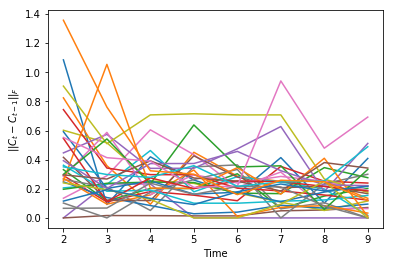

In [669]:
f = plt.figure()
for frob_norms in all_frob_norms:
    if len(frob_norms) == 8:
        plt.plot(np.arange(2, 10), frob_norms)
# team_diffs /= cnt
# plt.title('Consecutive Frobenius norm difference of influence matrix in every team')
plt.xlabel('Time')
plt.ylabel('$||C_t - C_{t-1}||_F$')
# plt.plot(np.arange(2, 10), team_diffs, 'p', color='black', label='Average')
plt.legend()
# f.savefig('consecutive_frob_norm_of_influence_matrices.pdf', bbox_inches='tight')
# f.savefig('consecutive_frob_norm_of_influence_matrices.png', bbox_inches='tight')

In [463]:
# aa = 0
# for influence_matrices in all_influence_matrices:
#     aa += len(influence_matrices) - 1
# print(aa)

# all_predicteds = []
# for influence_matrices in all_influence_matrices:
#     predicteds = []
#     for t in range(1, len(influence_matrices)):
#         err = 0
#         prev = influence_matrices[t - 1]
#         curr = influence_matrices[t]
#         predicted = np.zeros((4, 4))
#         for i in range(4):
#             predicted[i, i] = curr[i, i]
#             s = 0
#             for j in range(4):
#                 if i != j:
#                     s += prev[i, j]
#             if s != 0:
#                 for j in range(4):
#                     if i != j:
#                         predicted[i, j] = prev[i, j] * ((1 - curr[i, i]) / s)
#             else:
#                 predicted[i, j] = (1 - curr[i, i]) / 3
#         predicteds.append(predicted)
#     all_predicteds.append(predicteds)
    
# # errors = []
# exact_match_counter = 0
# same_order_counter = 0
# random_same_order_counter = 0
# all_counter = 0
# for i in range(len(all_influence_matrices)):
#     real_influence_matrices = all_influence_matrices[i]
#     predicted_influence_matrices = all_predicteds[i]
#     for t in range(1, len(real_influence_matrices)):
#         true_matrix = real_influence_matrices[t]
#         pred_matrix = predicted_influence_matrices[t - 1]
#         for i in range(4):
#             if np.sum(abs(true_matrix[i, :] - pred_matrix[i, :])) == 0:
#                 exact_match_counter += 1
#             others_indices = list(set(np.arange(4)) - set([i]))
#             if all(np.argsort(true_matrix[i, others_indices]) == np.argsort(pred_matrix[i, others_indices])):
#                 same_order_counter += 1
#             if all(np.argsort(true_matrix[i, others_indices]) == np.argsort(np.random.rand(3))):
#                 random_same_order_counter += 1
#             all_counter += 1
# #         errors.append(
# #             utils.matrix_estimation_error(
# #                 true_matrix, pred_matrix, type_str='mse'))

# print('Result:\nFor every row in the next influence matrix without diagonal entries, '
#       'for every individual, if we simply rescale previous influence given to '
#       'others by him or her, then =>\n***Out of {} influence distributions (rows in matrices), '
#       'exactly {}% of all of which were exact match. \n ***Also {}% of all had the same order. '
#       'This happens where if randomly order was picked, we would have {}% same order.'.format(
#         all_counter,
#         100 * exact_match_counter / all_counter,
#         100 * same_order_counter / all_counter,
#         100 * random_same_order_counter / all_counter))

Result:
For every row in the next influence matrix without diagonal entries, for every individual, if we simply rescale previous influence given to others by him or her, then =>
***Out of 1172 influence distributions (rows in matrices), exactly 41.21160409556314% of all of which were exact match. 
 ***Also 64.67576791808874% of all had the same order. This happens where if randomly order was picked, we would have 18.25938566552901% same order.


Message: This result is aligned with Noah's work (2011) and Mei's work (2017).

# Dynamic models: SBT, Mei's

## SBT

In [ ]:
# def ven_de_rijt_sbt(influence_matrix, mode = 1):
#     n, m = influence_matrix.shape
#     if n != m:
#         raise ValueError('The matrix was not squared.')
#     next_influence_matrix = np.zeros(influence_matrix.shape)
#     for i in range(n):
#         for j in range(n):
#             if i != j:
#                 ks = list(set.difference(set(range(n)), [i, j]))
#                 wij = 0
#                 for k in ks:
#                     wij += influence_matrix[i, k] * influence_matrix[k, j] 
# #                 wij /= (n - 2)
#                 next_influence_matrix[i, j] = wij

#     if mode == 1:
#         # Fill the diagonal with previous influence matrix and normalize to become row-stochastic.
#         np.fill_diagonal(next_influence_matrix, np.diag(influence_matrix))
#         next_influence_matrix = utils.make_matrix_row_stochastic(
#             next_influence_matrix)
#     elif mode == 2:
#         # Fill the diagonal with 1 - sum of the current filled row.
#         np.fill_diagonal(next_influence_matrix, 1 - np.sum(next_influence_matrix, axis=1))
#     else:
#         print('ERROR: mode was wrong. It was {}'.format(mode))
    
#     return next_influence_matrix

In [135]:
cnt = 0
mean_influence_matrix = np.zeros((4, 4))
all_influence_matrices = []
for team_id, team_log in data.items():
    if len(team_log.member_influences) < 9 or np.sum(team_log.member_influences_from_data[-1]) != 16:
        continue
    influence_matrices = []
    for inf_matrix in team_log.member_influences:
        influence_matrix = utils.make_matrix_row_stochastic(
            np.matrix(inf_matrix) / 100)
        influence_matrices.append(influence_matrix)
        mean_influence_matrix += influence_matrix
        cnt += 1
    all_influence_matrices.append(influence_matrices)
mean_influence_matrix /= cnt

## Mei's model

In [320]:
# Computing individual performances right before reporting the influence matrix.
hardness_weights = {
    pogs_jeopardy_log_lib.Level.EASY: 1,
    pogs_jeopardy_log_lib.Level.MEDIUM: 2,
    pogs_jeopardy_log_lib.Level.HARD: 3}

questions = data[37].game_info.questions
questions_order = data[37].question_order
individual_performances = {}
perf = {}
for team_id, team_log in data.items():
    perf[team_id] = defaultdict(
        lambda: {'#correct': 0,
                 '#questions': 0,
                 '#hardness_weighted_correct': 0,
                 '#hardness_weighted_questions': 0})
    individual_performances[team_id] = defaultdict(list)
    for qnum, qid in enumerate(questions_order):
        if qid in team_log.individual_answers_chosen:
            team_answers = team_log.individual_answers_chosen[qid]
            hardness_weight = hardness_weights[questions[qid].level]
            for member in team_log.members:
                if member in team_answers:
                    perf[team_id][member]['#questions'] += 1
                    perf[team_id][member]['#hardness_weighted_questions'] += hardness_weight
                    if questions[qid].answer == team_answers[member]:
                        perf[team_id][member]['#correct'] += 1
                        perf[team_id][member]['#hardness_weighted_correct'] += hardness_weight
        if (qnum + 1) % 5 == 0:
            for member in team_log.members:
                this_member_correct_rate = perf[team_id][member]['#correct'] / perf[team_id][member]['#questions']
#                 this_member_hardness_weighted_correct_rate = perf[team_id][member]['#hardness_weighted_correct'] / perf[team_id][member]['#hardness_weighted_questions']
                individual_performances[team_id][member].append(this_member_correct_rate)

In [ ]:
# RUNS = 10
# error_type_str = 'mse'
# sbt_mode = 1

# all_random_errors = []
# all_uniform_errors = []
# all_average_errors = []
# all_mei_errors = []
# all_sbt_errors = []
# all_last_errors = []

# for run in range(RUNS):
#     random_errors = []
#     uniform_errors = []
#     average_errors = []
#     mei_errors = []
#     sbt_errors = []
#     last_errors = []
#     for team_id, individual_performance in individual_performances.items():
#         team_log = data[team_id]
#         for t in range(len(team_log.member_influences) - 1):
#             influence_matrix = utils.make_matrix_row_stochastic(
#                 np.array(team_log.member_influences[t]) / 100)
#             next_influence_matrix_real = utils.make_matrix_row_stochastic(
#                 np.array(team_log.member_influences[t + 1]) / 100)
#             # Putting the performance of members in the same order as the influence matrices.
#             ps = []
#             for member in team_log.members:
#                 ps.append(individual_performance[member][t])
#             p_minus_Mp = np.diag(
#                 [ps[0] - (ps[1] + ps[2] + ps[3]) / 3,
#                  ps[1] - (ps[0] + ps[2] + ps[3]) / 3,
#                  ps[2] - (ps[0] + ps[1] + ps[3]) / 3,
#                  ps[3] - (ps[0] + ps[1] + ps[2]) / 3])
#             A_dot = (
#                 p_minus_Mp * np.diag(np.diag(influence_matrix)) * (np.eye(4, 4) - influence_matrix)) / (
#                 np.sum(ps))
#             mei_next_influence_matrix_predicted = influence_matrix + A_dot
#     #         mei_next_influence_matrix_predicted = utils.make_matrix_row_stochastic(
#     #             mei_next_influence_matrix_predicted)
#             mei_err = utils.matrix_estimation_error(
#                 next_influence_matrix_real, mei_next_influence_matrix_predicted, type_str=error_type_str)
#             mei_errors.append(mei_err)

#             uniform_errors.append(utils.matrix_estimation_error(
#                 next_influence_matrix_real, np.ones((4, 4)) * 0.25, type_str=error_type_str))

#             average_errors.append(utils.matrix_estimation_error(
#                 next_influence_matrix_real, mean_influence_matrix, type_str=error_type_str))

#             pred_next_matrix = ven_de_rijt_sbt(influence_matrix, mode=sbt_mode)
#             sbt_err = utils.matrix_estimation_error(
#                 next_influence_matrix_real, pred_next_matrix, type_str=error_type_str)
#             sbt_errors.append(sbt_err)

#             # Random model prediction:
#             rand_err = utils.matrix_estimation_error(
#                 next_influence_matrix_real, utils.make_matrix_row_stochastic(
#                     np.random.rand(4, 4)), type_str=error_type_str)
#             random_errors.append(rand_err)

#             # Last:
#             last_err = utils.matrix_estimation_error(next_influence_matrix_real, influence_matrix)
#             last_errors.append(last_err)
            
#     all_random_errors.append(np.mean(random_errors))
#     all_uniform_errors.append(np.mean(uniform_errors))
#     all_average_errors.append(np.mean(average_errors))
#     all_mei_errors.append(np.mean(mei_errors))
#     all_last_errors.append(np.mean(last_errors))

In [529]:
error_type_str = 'mse'
sbt_mode = 1

random_errors = []
uniform_errors = []
average_errors = []
mei_errors = []
sbt_errors = []
last_errors = []
for team_id, individual_performance in individual_performances.items():
    team_log = data[team_id]
    for t in range(len(team_log.member_influences) - 1):
        influence_matrix = utils.make_matrix_row_stochastic(
            np.array(team_log.member_influences[t]) / 100)
        next_influence_matrix_real = utils.make_matrix_row_stochastic(
            np.array(team_log.member_influences[t + 1]) / 100)
        # Putting the performance of members in the same order as the influence matrices.
        ps = []
        for member in team_log.members:
            ps.append(individual_performance[member][t])
        
#         # From average of others:
#         p_minus_Mp = np.diag(
#             [ps[0] - (ps[1] + ps[2] + ps[3]) / 3,
#              ps[1] - (ps[0] + ps[2] + ps[3]) / 3,
#              ps[2] - (ps[0] + ps[1] + ps[3]) / 3,
#              ps[3] - (ps[0] + ps[1] + ps[2]) / 3])
        
        # From average of all:
        p_minus_Mp = np.diag(ps - np.sum(ps) / 4)

        A_dot = (
            p_minus_Mp * np.diag(np.diag(influence_matrix)) * (np.eye(4, 4) - influence_matrix)) / (
            np.sum(ps))
        mei_next_influence_matrix_predicted = influence_matrix + A_dot
#         mei_next_influence_matrix_predicted = utils.make_matrix_row_stochastic(
#             mei_next_influence_matrix_predicted)
        mei_err = utils.matrix_estimation_error(
            next_influence_matrix_real, mei_next_influence_matrix_predicted, type_str=error_type_str)
        mei_errors.append(mei_err)

        uniform_errors.append(utils.matrix_estimation_error(
            next_influence_matrix_real, np.ones((4, 4)) * 0.25, type_str=error_type_str))
        
        average_errors.append(utils.matrix_estimation_error(
            next_influence_matrix_real, mean_influence_matrix, type_str=error_type_str))
        
        pred_next_matrix = ven_de_rijt_sbt(influence_matrix, mode=sbt_mode)
        sbt_err = utils.matrix_estimation_error(
            next_influence_matrix_real, pred_next_matrix, type_str=error_type_str)
        sbt_errors.append(sbt_err)
        
        # Random model prediction:
        rand_err = utils.matrix_estimation_error(
            next_influence_matrix_real, utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)), type_str=error_type_str)
        random_errors.append(rand_err)
        
        # Last:
        last_err = utils.matrix_estimation_error(next_influence_matrix_real, influence_matrix)
        last_errors.append(last_err)

Mei's: 0.006573223286526493 +- 0.010920828037748812
Uniform: 0.012643031224390035 +- 0.013281079068406684
Average: 0.0119561758029185 +- 0.011994640886979128
SBT: 0.020203093472782287 +- 0.014042729123765082
Random: 0.032768809071880005 +- 0.01707167389120818
Last: 0.23930105912936736 +- 0.1521636104367098


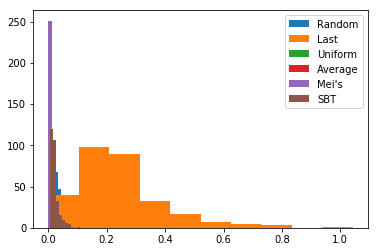

In [530]:
plt.hist(random_errors)
plt.hist(last_errors)
plt.hist(uniform_errors)
plt.hist(average_errors)
plt.hist(mei_errors)
plt.hist(sbt_errors)
plt.legend(['Random', 'Last', 'Uniform', 'Average', 'Mei\'s', 'SBT'])

print('Mei\'s: {} +- {}'.format(np.mean(mei_errors), np.std(mei_errors)))
print('Uniform: {} +- {}'.format(np.mean(uniform_errors), np.std(uniform_errors)))
print('Average: {} +- {}'.format(np.mean(average_errors), np.std(average_errors)))
print('SBT: {} +- {}'.format(np.mean(sbt_errors), np.std(sbt_errors)))
print('Random: {} +- {}'.format(np.mean(random_errors), np.std(random_errors)))
print('Last: {} +- {}'.format(np.mean(last_errors), np.std(last_errors)));